# Initialization

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop
import datetime
import time
import random
import shutil
import sys
from enum import Enum, auto
from bs4 import BeautifulSoup
from numpy import asarray, arange, mgrid, ndarray
from PIL import Image, ImageDraw
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense
from tensorflow.keras.layers import Flatten, Dropout
from tensorflow.keras import Input, Model
import matplotlib.patches as patches

###Settings

In [ ]:
targetSizeElement = 128
maxImages=1
training_img_dir="/content/drive/MyDrive/tf_workspace/Images/Location_Images/bee3"

In [ ]:
def loadImage(filename: str, imgSize:int = 64) -> ndarray:
    image = Image.open(filename)
    width, height = image.size
    image = image.resize(size=(imgSize, imgSize), resample=Image.NEAREST)
    np_data = np.array(image).astype('float32')/255
    #np_image = np.expand_dims(np_data, axis=0)
    return np_data, imgSize/width, imgSize/height#np_image

In [ ]:
#maxImages
def getClassIndexList(value, classList: list)->list:
  returnList = [0] * len(classList)
  for index, element in enumerate(classList):
    if element == value:
      returnList[index] = 1
  return returnList
X = []
#Output = []
Y_train = []
Y_val = []

#Z = []
Classlist = []
OverLength = []
imageCounter = 0
trainingFileDirList = os.listdir(training_img_dir)
random.shuffle(trainingFileDirList)
for files in trainingFileDirList:
  file_name, file_extension = os.path.splitext(files)
  if(file_extension == ".xml"):
    imageCounter += 1
    filePath = os.path.join(training_img_dir, files)
    with open(filePath, 'r') as f:
      data = f.read()
      Bs_data = BeautifulSoup(data, "xml")
      b_name = Bs_data.find('name')
      for items in Classlist:
        if(items == b_name.string):
          break
      else:
        Classlist.append(b_name.string) 
trainImageCount = int(imageCounter * (1-0.2))
valImageCount = int(imageCounter * 0.2)
if(trainImageCount + valImageCount < imageCounter):
  diff = imageCounter - trainImageCount - valImageCount
  trainImageCount += diff
X_train = np.zeros((trainImageCount, targetSizeElement, targetSizeElement,3))
X_val = np.zeros((valImageCount, targetSizeElement, targetSizeElement,3))

Y_train.append(np.zeros((trainImageCount, 4)))
Y_val.append(np.zeros((valImageCount, 4)))

for count in range(maxImages): 
  Y_train.append(np.zeros((trainImageCount, 4)))
  Y_train.append(np.zeros((trainImageCount, len(Classlist))))
for count in range(maxImages): 
  Y_val.append(np.zeros((valImageCount, 4)))
  Y_val.append(np.zeros((valImageCount, len(Classlist))))
sectionCount = -1

for files in os.listdir(training_img_dir):
  file_name, file_extension = os.path.splitext(files)
  if(file_extension == ".xml"):
    sectionCount+= 1
    filePath = os.path.join(training_img_dir, files)
    with open(filePath, 'r') as f:
      data = f.read()
      Bs_data = BeautifulSoup(data, "xml")
      b_unique = Bs_data.find_all('object')
      random.shuffle(b_unique)
      if(len(b_unique)>maxImages):
        if(sectionCount < trainImageCount):
          Y_train[0][sectionCount] = 1
        else:
          Y_val[0][sectionCount-trainImageCount] = 1
      else:
        if(sectionCount < trainImageCount):
          Y_train[0][sectionCount] = 0
        else:
          Y_val[0][sectionCount-trainImageCount] = 0
      if(True):
      #if(len(b_unique)<=maxImages):
        file2 = file_name + ".jpg"
        filePath2 = os.path.join(training_img_dir, file2)
        imageLoaded, widthFactor, heightFactor = loadImage(filePath2, targetSizeElement)
        if(sectionCount < trainImageCount):
          X_train[sectionCount] = imageLoaded
        else:
          try:
            X_val[sectionCount-trainImageCount] = imageLoaded
          except ValueError:
            print(file_name,file_extension)
            print(filePath2)
        for index in range(0,maxImages):
          try:
            b_name = b_unique[index].find('name')
            b_loc = b_unique[index].find('bndbox')
            tempClassList = getClassIndexList(b_name.string, Classlist) 
            x = (int(b_loc.find('xmin').string)* widthFactor)#/targetSizeElement
            y = (int(b_loc.find('ymin').string)*heightFactor)#/targetSizeElement
            w = (int(b_loc.find('xmax').string)*widthFactor)-x#/targetSizeElement - x
            h = (int(b_loc.find('ymax').string)*heightFactor)-y#/targetSizeElement - y
            #print(x,y,w,h)
            if(index == 1):
              #print(sectionCount)
              pass
          except IndexError:
            #print(index)
            #print(b_unique)
            tempClassList = [0] * len(Classlist)
            x = 0
            y = 0
            w = 0
            h = 0
          if(sectionCount < trainImageCount):
            Y_train[(index)*2+1][sectionCount] =[x,y,w,h]
            Y_train[(index)*2+2][sectionCount] = tempClassList
          else:
            Y_val[(index)*2+1][sectionCount-trainImageCount] =[x,y,w,h]
            Y_val[(index)*2+2][sectionCount-trainImageCount] = tempClassList  
            if(len(b_unique)>maxImages): OverLength.append(sectionCount-trainImageCount)

#X = np.array(X)
#Y = np.array(Y)
  
print(len(X_train))
print(len(X_val))
print(len(Y_train[0]))
print(len(Y_train[1]))
#print(len(Z))

3990
997
3990
3990


In [ ]:
def getImageSection(image:np.ndarray, shape:tuple):
    (xmin, ymin, xmax, ymax) = shape
    return image[:, ymin:ymax, xmin:xmax]

### Load Model

In [ ]:
print(OverLength)

[83, 121, 123, 283, 310, 311, 322, 330, 351, 357, 376, 383, 385, 386, 387, 391, 392, 394, 395, 396, 397, 398, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 412, 414, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 449, 450, 451, 452, 453, 457, 458, 459, 460, 461, 462, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 485, 487, 569, 621, 675, 791, 993, 994]


In [ ]:
modelPath = "/content/drive/MyDrive/tf_workspace/CNN/Localisation/Custom_Detection_v2/savedModela/"
#model = tf.saved_model.load(modelPath)
model = tf.keras.models.load_model(modelPath)

In [ ]:
indexList = []
for index, element in enumerate(Y_val[0]):
  if(element.tolist()[0] == 1):
    indexList.append(index)
print(indexList)

[83, 121, 123, 283, 310, 311, 322, 330, 351, 357, 376, 383, 385, 386, 387, 391, 392, 394, 395, 396, 397, 398, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 412, 414, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 449, 450, 451, 452, 453, 457, 458, 459, 460, 461, 462, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 485, 487, 569, 621, 675, 791, 993, 994]


In [ ]:
def analizeImageSections(image):
  sections = []
  #print(image.shape)
  _, imageSize, _,_ = image.shape
  imageSectionSize = int(imageSize/2)
  sections.append((0,0,imageSectionSize,imageSectionSize))
  sections.append((0,imageSectionSize,imageSectionSize,2*imageSectionSize))
  sections.append((imageSectionSize,0,2*imageSectionSize,imageSectionSize))
  sections.append((imageSectionSize,imageSectionSize,2*imageSectionSize,2*imageSectionSize))
  for index,element in enumerate(sections):
    imageSection = getImageSection(image, element)
    predictImage = transform.resize(imageSection, (1,targetSizeElement, targetSizeElement, 3))
    #print(imageSection.shape)
    predictions = model.predict(predictImage)
    showPredictions(predictImage[0], predictions)
    if(predictions[0]>0.8):
      analizeImageSections(imageSection)

In [ ]:
def showPredictions(image, predictions):
  print("Bee, Insect, BumbleBee, Vespula")
  plt.imshow(image)
  ax = plt.gca()
  for index in range(0,maxImages):
    print(predictions[0])
    rect = patches.Rectangle((predictions[index*2+1][0][0]*targetSizeElement, predictions[index*2+1][0][1]*targetSizeElement), predictions[index*2+1][0][2]*targetSizeElement, predictions[index*2+1][0][3]*targetSizeElement, linewidth=1, edgecolor='r', facecolor='none')
    #rect = patches.Rectangle((predictions[index*2+1][0][0], predictions[index*2+1][0][1]), predictions[index*2+1][0][2], predictions[index*2+1][0][3], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    #print(predictions[index*2+1][0])
    new_list = [ str(round(x*100,1))+"%" for x in predictions[index*2+2][0]]

    #new_list = ["64.9%", "29.9%", "58.9%"]
    #print(predictions[index*2+2][0])
    print(new_list)
    #print(predictions[index*2+1][0][0], predictions[index*2+1][0][1], predictions[index*2+1][0][2], predictions[index*2+1][0][3])
    #print(predictions[index*2+1][0][0]*targetSizeElement, predictions[index*2+1][0][1]*targetSizeElement, predictions[index*2+1][0][2]*targetSizeElement, predictions[index*2+1][0][3]*targetSizeElement)
  #rect = patches.Rectangle((predictions[2][0][0], predictions[2][0][1]), predictions[2][0][2], predictions[2][0][3], linewidth=1, edgecolor='r', facecolor='none')
  # Add the patch to the Axes
  #ax.add_patch(rect)
  plt.show()

0
1/1 [==============================] - 0s 29ms/step
Bee, Insect, BumbleBee, Vespula
[[2.4442994e-05]]
['0.0%', '99.9%', '0.1%', '0.0%']


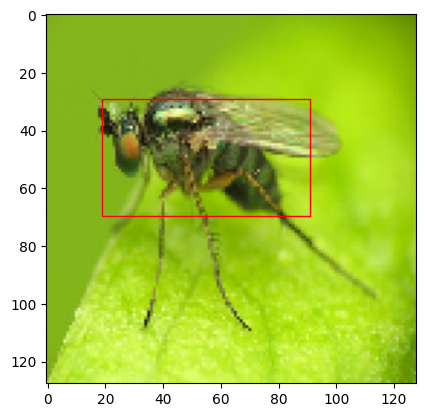

In [ ]:
import matplotlib.patches as patches
from skimage import transform
imageNumber = random.randint(0, len(indexList))
print(imageNumber)
#testVal = X_val[indexList[imageNumber]]
testVal = X_val[imageNumber]
testImage = testVal
testVal = np.expand_dims(testVal, axis=0)
predictions = model.predict(testVal)
plt.imshow(testImage)
ax = plt.gca()
if(predictions[0]> 0.8):
    analizeImageSections(testVal)
showPredictions(testVal[0], predictions)
  #print(f"Are there more objects {bool(int(predictions[0]))} {predictions[0]}")
  #print(Classlist)
  #print("Bee, Insect, BumbleBee, Vespula")
  #for index in range(0,maxImages):
  #  rect = patches.Rectangle((predictions[index*2+1][0][0]*targetSizeElement, predictions[index*2+1][0][1]*targetSizeElement), predictions[index*2+1][0][2]*targetSizeElement, predictions[index*2+1][0][3]*targetSizeElement, linewidth=1, edgecolor='r', facecolor='none')
    #rect = patches.Rectangle((predictions[index*2+1][0][0], predictions[index*2+1][0][1]), predictions[index*2+1][0][2], predictions[index*2+1][0][3], linewidth=1, edgecolor='r', facecolor='none')
  #  ax.add_patch(rect)
    #print(predictions[index*2+1][0])
  #  new_list = [ str(round(x*100,1))+"%" for x in predictions[index*2+2][0]]

    #new_list = ["64.9%", "29.9%", "58.9%"]
    #print(predictions[index*2+2][0])
  #  print(new_list)
 #   #print(predictions[index*2+1][0][0], predictions[index*2+1][0][1], predictions[index*2+1][0][2], predictions[index*2+1][0][3])
    #print(predictions[index*2+1][0][0]*targetSizeElement, predictions[index*2+1][0][1]*targetSizeElement, predictions[index*2+1][0][2]*targetSizeElement, predictions[index*2+1][0][3]*targetSizeElement)
  #rect = patches.Rectangle((predictions[2][0][0], predictions[2][0][1]), predictions[2][0][2], predictions[2][0][3], linewidth=1, edgecolor='r', facecolor='none')
  # Add the patch to the Axes
  #ax.add_patch(rect)
  #plt.show()

In [ ]:
import matplotlib.patches as patches
imageNumber = random.randint(0, len(X_train))
print(imageNumber)
testVal = X_train[imageNumber]
testImage = testVal
testVal = np.expand_dims(testVal, axis=0)
predictions = model.predict(testVal)
plt.imshow(testImage)
ax = plt.gca()
print(f"Are there more objects {bool(int(predictions[0]))} {predictions[0]}")
print(Classlist)
for index in range(0,maxImages):
  rect = patches.Rectangle((predictions[index*2+1][0][0]*targetSizeElement, predictions[index*2+1][0][1]*targetSizeElement), predictions[index*2+1][0][2]*targetSizeElement, predictions[index*2+1][0][3]*targetSizeElement, linewidth=1, edgecolor='r', facecolor='none')
  #rect = patches.Rectangle((predictions[index*2+1][0][0], predictions[index*2+1][0][1]), predictions[index*2+1][0][2], predictions[index*2+1][0][3], linewidth=1, edgecolor='r', facecolor='none')
  ax.add_patch(rect)
  print(predictions[index*2+1][0])
  print(predictions[index*2+2][0])
  print(predictions[index*2+1][0][0], predictions[index*2+1][0][1], predictions[index*2+1][0][2], predictions[index*2+1][0][3])
  print(predictions[index*2+1][0][0]*targetSizeElement, predictions[index*2+1][0][1]*targetSizeElement, predictions[index*2+1][0][2]*targetSizeElement, predictions[index*2+1][0][3]*targetSizeElement)
#rect = patches.Rectangle((predictions[2][0][0], predictions[2][0][1]), predictions[2][0][2], predictions[2][0][3], linewidth=1, edgecolor='r', facecolor='none')
# Add the patch to the Axes
#ax.add_patch(rect)
plt.show()

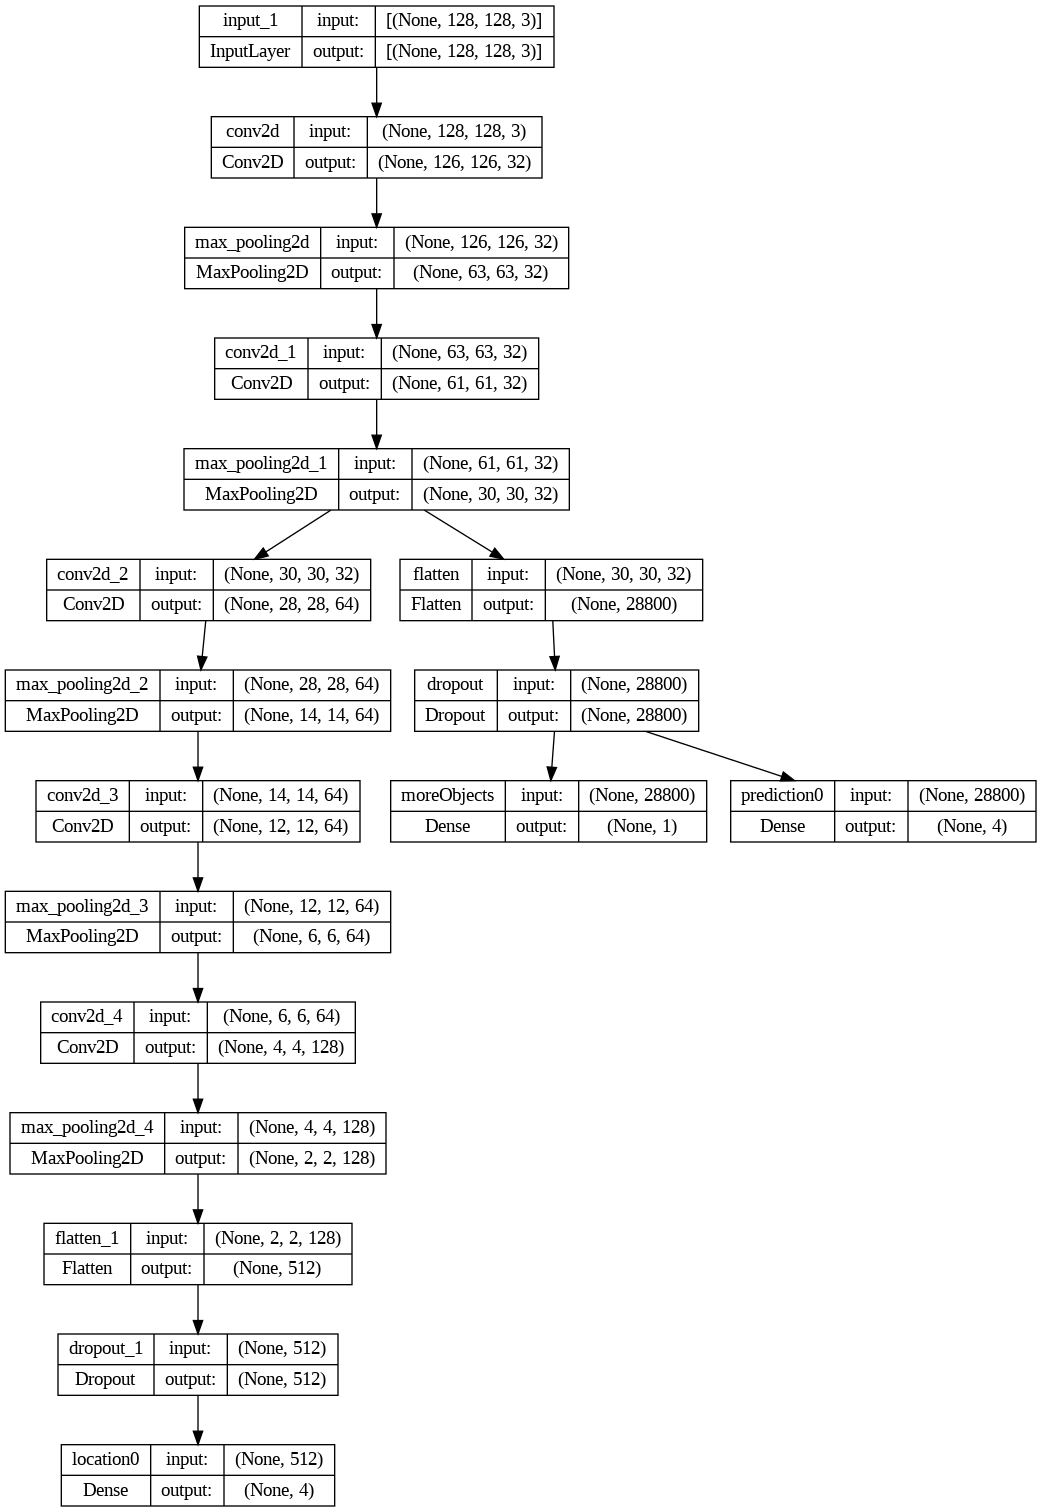

In [ ]:
from tensorflow.keras.utils import plot_model
imageLocation = "/content/drive/MyDrive/tf_workspace/"+modelFolderName+f"/{modelFolderName}.jpg"
plot_model(model, show_shapes=True)